In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split
from torchvision import models
import os
import time
import random
import copy

In [25]:
data_dir = r'D:\subway\SUBWAY\SUBWAY'

In [26]:

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [27]:
os.listdir(data_dir)

['down', 'left', 'noop', 'right', 'up']

In [28]:
for class_dir in os.listdir(data_dir):
  class_path= os.path.join(data_dir,class_dir)
  if os.path.isdir(class_path):
    print(f'Class:{class_dir},Files:{len(os.listdir(class_path))}')

Class:down,Files:640
Class:left,Files:1458
Class:noop,Files:1019
Class:right,Files:1487
Class:up,Files:1314


In [29]:


# Load the full dataset from the 'SUBWAY' folder
full_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

In [30]:
# Split the dataset into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [31]:
# Apply the validation transformation to the validation set
val_dataset.dataset.transform = data_transforms['val']


In [32]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}


In [33]:
# Get dataset sizes and class names
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

In [34]:
# Check if GPU is available
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cpu')

In [35]:
# Check if GPU is available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:

# Output summary of data loading
print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")
print(f"Classes: {class_names}")

Training set size: 4734
Validation set size: 1184
Classes: ['down', 'left', 'noop', 'right', 'up']


In [37]:

# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes (5)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

# Move the model to the device
model = model.to(device)

# Define the loss function and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define a learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


c:\Users\ABHIRAM\anaconda3\envs\amazonml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Adjust the learning rate in the training phase
            if phase == 'train':
                scheduler.step()

            # Calculate loss and accuracy for each phase
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Calculate total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [39]:

# Train the model for 10
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------


KeyboardInterrupt: 

In [17]:
# Save the model
model_path = 'D:\subway\SUBWAY\subway_surfer_model.pth'
torch.save(model.state_dict(), model_path)

print(f'Model saved to {model_path}') 


Model saved to D:\subway\SUBWAY\subway_surfer_model.pth


In [52]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random

# Load the saved model
# Specify map_location to handle device compatibility
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units

# Load the model state
try:
    model.load_state_dict(torch.load('D:\subway\subway_surfer_model.pth', map_location='cpu'))  # Use 'cpu' or 'cuda'
except Exception as e:
    print(f"Error loading model: {e}")

model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 5)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:5]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:5]

# Now you can use new_model for inference


C:\Users\ABHIRAM\AppData\Local\Temp\ipykernel_7800\1443055446.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\subway\subway_surfer_

Error loading model: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([5, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1000]).


In [42]:
classes=class_names
classes

['down', 'left', 'noop', 'right', 'up']

In [62]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)  # Adjust to match the desired output units

# Load the model state
model.load_state_dict(torch.load('D:/subway/subway_surfer_model.pth', map_location='cpu'))  # Use 'cpu' or 'cuda'
model.eval()

C:\Users\ABHIRAM\AppData\Local\Temp\ipykernel_7800\1609626062.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:/subway/subway_surfer_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:


# Define the image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


The predicted class is: noop


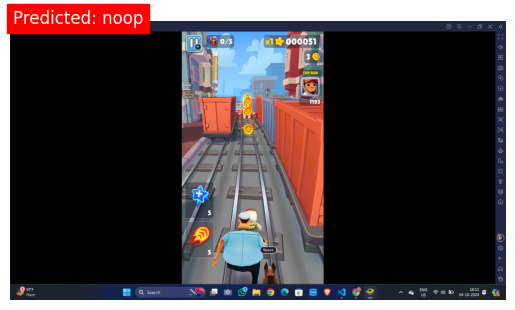

In [85]:
# Perform inference
image_path = r'C:\Users\ABHIRAM\Pictures\Screenshots\Screenshot 2024-10-04 181111.png'  # Replace with your image path
input_batch = preprocess_image(image_path)
image=Image.open(image_path)

with torch.no_grad():
    output = model(input_batch)  # This should now work without error

# Get the predicted class
_, predicted_class = output.max(1)

predicted_class_name = ['down', 'left', 'noop', 'right', 'up'][predicted_class.item()]
print(f'The predicted class is: {predicted_class_name}')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()